In [6]:
import time
from typing import Tuple

import numpy as np
import pandas as pd
from scipy.stats import shapiro
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Things that belong to strongly predictions, we just remove this
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']

# Define nominal and binary columns
# numeric is calculated using above 2.
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']


def define_numeric_column(data: pd.DataFrame):
    # Define numeric columns dynamically based on the dataframe
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]


def print_score():
    # Calculate other evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"NAIVE BAYES CLASSIFIER")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Decision Tree Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))


def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:  # Arbitrary threshold (e.g., 5% gap)
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:  # Arbitrary low threshold
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")


def preprocess_data(data: pd.DataFrame) -> tuple:
    data = data.copy()
    # Data cleaning
    data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
    # Define columns
    numeric = define_numeric_column(data)
    return data[nominal + numeric + binary], data['attack_category']


def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

def check_gaussian_assumption(data: pd.DataFrame, numeric_cols):
    # Check if numeric features follow a Gaussian distribution using Shapiro-Wilk test
    print("\nGaussian Assumption Check for Numeric Features (First 5):")
    for col in numeric_cols[:5]:
        stat, p = shapiro(data[col].dropna())
        print(f"{col}: p-value = {p:.4f} {'(Non-Gaussian)' if p < 0.05 else '(Gaussian)'}")

# Load and preprocess data
df = pd.read_csv('kdd_merged.csv')

X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Scale numerical features (helpful for GaussianNB stability)
numeric_cols = define_numeric_column(df)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Check Gaussian assumption for numeric features
check_gaussian_assumption(X, numeric_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature selection - Select top 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Report selected features
selected_features = X.columns[selector.get_support()].tolist()
print("\nTop 20 Selected Features:")
print(selected_features)

# Calculate class priors from training data (optional override)
class_counts = y_train.value_counts(normalize=True)
# class_priors = [0.5, 0.3, 0.1, 0.05, 0.05] # These values are based on assumption, and accommodate for Rarity.
# By Default lets give them zero and test it once.
class_priors = [class_counts.get(cls, 0.0) for cls in ['normal', 'DoS', 'Probe', 'R2L', 'U2R']]
print("\nComputed Class Priors from Training Data:")
print(f"Benign: {class_priors[0]:.4f}, DoS: {class_priors[1]:.4f}, Probe: {class_priors[2]:.4f}, "
      f"R2L: {class_priors[3]:.4f}, U2R: {class_priors[4]:.4f}")

# Hyperparameter tuning for GaussianNB
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],  # Range of smoothing values
    'priors': [None, class_priors]  # None (default!) for data-driven, class_priors for custom
}
nb_model = GaussianNB()
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
training_time = time.time() - start_time

# Best model
best_nb_model = grid_search.best_estimator_
print(f"\nBest Parameters:")
print(f"var_smoothing: {grid_search.best_params_['var_smoothing']}")
print(f"priors: {'Data-driven' if grid_search.best_params_['priors'] is None else 'Custom'}")
print(f"Best CV Weighted F1 Score: {grid_search.best_score_:.4f}")

# Predictions
y_train_pred = best_nb_model.predict(X_train_selected)
y_test_pred = best_nb_model.predict(X_test_selected)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print_score()
check_fitting()

# Cross-validation for robustness
cv_scores = cross_val_score(best_nb_model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
print(f"\n5-Fold Cross-Validation Weighted F1 Scores: {cv_scores}")
print(f"Average CV F1 Score: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")


Gaussian Assumption Check for Numeric Features (First 5):
duration: p-value = 0.0000 (Non-Gaussian)
src_bytes: p-value = 0.0000 (Non-Gaussian)
dst_bytes: p-value = 0.0000 (Non-Gaussian)
wrong_fragment: p-value = 0.0000 (Non-Gaussian)
urgent: p-value = 0.0000 (Non-Gaussian)


/opt/python/3.7/tensorflow-gpu/2.2.0_py3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Top 20 Selected Features:
['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'logged_in']

Computed Class Priors from Training Data:
Benign: 0.0000, DoS: 0.0000, Probe: 0.0000, R2L: 0.0000, U2R: 0.0000

Best Parameters:
var_smoothing: 1e-06
priors: Data-driven
Best CV Weighted F1 Score: 0.8253
NAIVE BAYES CLASSIFIER

Classification Report:
               precision    recall  f1-score   support

      benign       0.92      0.74      0.82     15411
         dos       0.97      0.90      0.93     10713
       probe       0.81      0.66      0.73      2816
         r2l       0.20      0.80      0.32       714
         u2r       0.02      0.70      0.03        50

    accuracy     

ROC

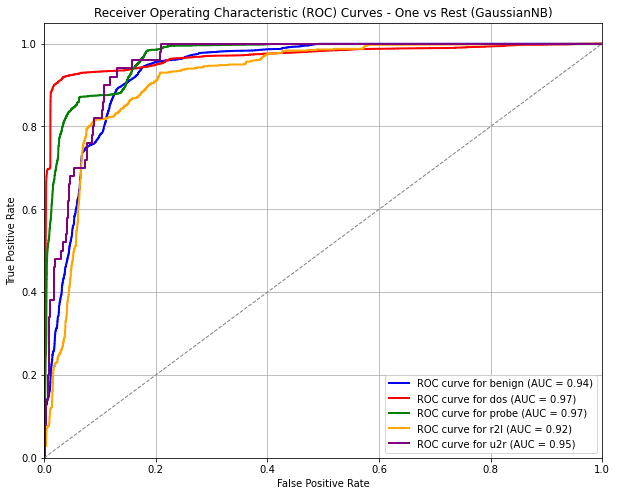


ROC AUC Scores for Each Class:
benign: 0.9359
dos: 0.9698
probe: 0.9679
r2l: 0.9188
u2r: 0.9521


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve():
    # Get unique classes from y_test
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Binarize the test labels for one-vs-rest ROC
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get predicted probabilities for the test set
    y_test_prob = best_nb_model.predict_proba(X_test_selected)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()  # False Positive Rate
    tpr = dict()  # True Positive Rate
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust if >5 classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal line (random guessing)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves - One vs Rest (GaussianNB)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Print AUC scores for each class
    print("\nROC AUC Scores for Each Class:")
    for i in range(n_classes):
        print(f"{classes[i]}: {roc_auc[i]:.4f}")

plot_roc_curve()